# Lecture 4
We will now look at ways to run a computational process and monitor it as it performs the assigned task. At some moment our algorithm will decide that solution progressed enough to make some decision and will restart it with parameters changed according to what we programmed. The task itself, the communication and the process will vary greatly from case to case, but in general we will need to:
* Start an external application with proper command line arguments.
    * This can be done either in a blocking (the thread serving our Python console will not be accessible, and will lock for the execution of the called program)
    * Or in a nonblocking way, by spawning a separate process to deal with the problem, while our Python console will return control for us to perform various tasks.
* Read data from a file to which the program stores the interesting value.
* Modify settings of the program, either via command line arguments or a setting file.
* Make decisions on what to do next.

**Note**: I use more less this approach to (attempt) track the edge that possibly exists between the laminar and turbulent solution, by iteratively changing perturbation applied to the flow end examining its evolution in time, on the way deciding if the flow is going turbulent or not. The process is very much like trying to push the ball to land on the top of a hill, push it to hard and it passes to the other side, be to gentle and it will not reach the top. But in an infinite number of dimensions (before discretization).

## The model program
For a given task you will need to use a specific program. For me this is a flow solver, for you it might be ANSYS or ADAMS or something completely different. For the purpose of this presentation we will use a simple C++ program, attached to this repository. (This might not be working with MyBinder though). This program:
* stores a random value from a selected range to a file - our data.
* accepts some simple command line arguments.
* Reads a simplistic setting file.
* The source is in the tick-tick folder.

## Use `os.system` call
We start by simply calling the system command, in our case our program. To do this we need to import `os` module:

In [1]:
import os

In [2]:
#os.system('./tick-tick/build_debug/tick-tick')
os.system('./tick-tick/build_debug/tick-tick --period 10')

0

This executes `tick-tick` program, the working directory (place where work is performed is) is the same as our current working directory. As a result `data.dat` should appear. The file content is:

In [3]:
cat data.dat

# Recording precious random data
# t, value
# Settings: 10 0.1 1 -1 10
0,	 -0.736924
0.1,	 -0.0826997
0.2,	 -0.562082
0.3,	 0.357729
0.4,	 0.869386
0.5,	 0.0388327
0.6,	 -0.930856
0.7,	 0.0594004
0.8,	 -0.984604
0.9,	 -0.866316


In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
t, v = np.loadtxt('data.dat', comments="#", skiprows=2, usecols=(0,1), unpack=True, delimiter=',')

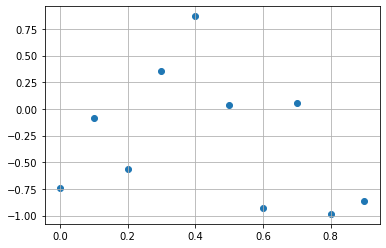

In [6]:
plt.scatter(t, v)
plt.grid()

Before proceeding lets add setting file we can manipulate:

In [7]:
f = open('./settings', 'w')
f.writelines('DT   = 0.5\n')
f.write('XMAX = 5.0\n')
f.write('XMIN = -5.0\n')
f.write('N    = 100\n')
f.close()

Now we have a settings file to be passed to our process.

In [8]:
os.system('./tick-tick/build_debug/tick-tick --period 10 --sett settings')

0

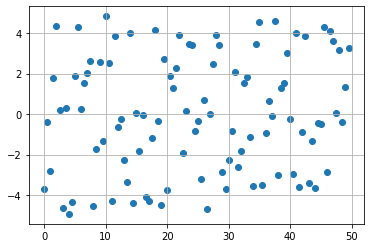

In [9]:
t, v = np.loadtxt('data.dat', comments="#", skiprows=2, usecols=(0,1), unpack=True, delimiter=',')
plt.scatter(t, v)
plt.grid()

## `subprocess`
### Blocking call:
Ultimately we would like to run the program and regain control. To this end we will use the `subprocess` module and a couple of `os` tools. The `subprocess` module allows to create new processes, obtain their returns and outputs. We will show only some of the functionality. Let's start with getting the output with `check_output`, that we can later parse and use:

In [10]:
import subprocess

In [16]:
s = subprocess.check_output(["ls", "-l"])
print(s)

b'total 72\n-rw-rw-r-- 1 sgepner sgepner  1525 kwi  7 13:41 data.dat\n-rw-rw-r-- 1 sgepner sgepner 58042 kwi  7 13:39 Lecture 4.ipynb\n-rw-rw-r-- 1 sgepner sgepner    45 kwi  7 13:38 settings\ndrwxrwxr-x 4 sgepner sgepner  4096 kwi  7 13:27 tick-tick\n'


For us, more useful is `call()`. It runs command passed as argument and waits (locks control) until command completes. 

In [18]:
subprocess.call("tick-tick/build_debug/tick-tick --period 50 --sett settings", shell=True)

0

Note the additional `shell=True` argument. This specifies that the command will be executed through the system shell (eg. Bash) and is useful if wee need to pass arguments. We can illustrate the result:

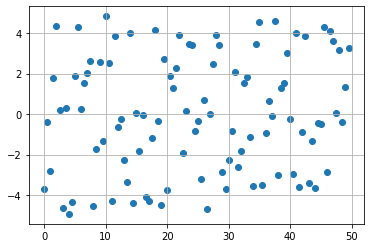

In [19]:
t, v = np.loadtxt('data.dat', comments="#", skiprows=2, usecols=(0,1), unpack=True, delimiter=',')
plt.scatter(t, v)
plt.grid()

Example: Using the `tick-tick` program and the `call` function write a script that runs the `tick-tick` changing the number of iterations N and plots average and variance as functions of N.

1. Write a function that modifies the setting file accordingly.
2. Write a function that reads the result file and stores the results.
3. Run the process in a loop, choose some stopping criteria.

In [20]:
def settfile(fname, N):
    '''
    Modifies the setting file
    param: fname - file to modify
    param: N - nuber of iteration do perform
    '''
    pass

In [ ]:
def calculate(fname):
    '''
    Using fname calculates average and variance
    '''
    avg = var = 0
    return avg, var

In [ ]:
'''
Run the process here
'''
while True:
    
    break

### Run and regain control with `popen()`
We will now look at a slight modification. Our goal is to be able to monitor (programmatically) the process we call and if necessary make decision, change parameters and eventually stop execution or restart. To do this we need to add a couple of things to our tool set. Fist is the `subprocess.Popen()`, which works very much like `call()`, with a difference that it executes the child (mercy!) in a new process! What that means is that new, separate from our Python interpreter, process is started to handle the program, and control is returned to the interpreter to perform whatever task we wish it to do. When called `Popen` object is returned. We will outline some of functionality it provides (also see the documentation).

**The most important feature is that `Popen()` allows a nonblocking call!**

In [1]:
import subprocess

Note: It is good to show the process tree at this moment.

In [53]:
p=subprocess.Popen('tick-tick/build_debug/tick-tick --period 100 --sett settings', shell=True)

`p` is going to be a `Popen` with which we (or our smart algorithm) can interact. There is a number of things we could do. The most important is to check if the child process is alive (`Popen.poll()`), wait for it to finish with (`Popen.wait(timeout)`), or send it a signal for termination or kill (`Popen.terminate() .kill()`). There is also an option to interact with the process passing data to `stdin` and to read from `stdout` with `Popen.communicate()`, but our program does not support this (you can try it out).

Examine:
* `p.poll()`
* `p.wait()`
* `p.pid`
* `p.terminate()` and `p.kill()`

In [54]:
p.terminate()

In [51]:
print(p.wait())

0


In [46]:
print(p.returncode)

0


In [26]:
print(p)

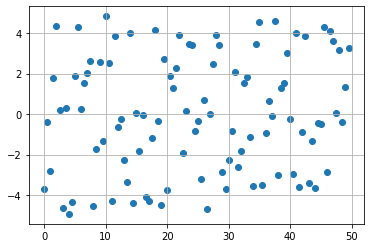

In [27]:
t, v = np.loadtxt('data.dat', comments="#", skiprows=2, usecols=(0,1), unpack=True, delimiter=',')
plt.scatter(t, v)
plt.grid()